In [49]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk
import csv
import re
from nltk import corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [50]:
# get data in notebook
df = pd.read_csv(r"C:\Users\tonym\Documents\Flatiron\phase_5\capstone\MBTI-ML-Social-Media-\data\mbti_1.csv")

In [51]:
# check top and bottom of data set 
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [52]:
df.tail()

,type,posts
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...
8674,INFP,'It has been too long since I have been on per...


In [53]:
# 
df.shape

(8675, 2)

Over 8500 rows. Posts and type appear to be the only columns.

In [54]:
# check for null values in the set 
df.isnull().sum()

type     0
posts    0
dtype: int64

In [55]:
df.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,"'INTP female. Most: ENTJ, ESTJ, ENFJ Least: I..."
freq,1832,1


no null values 

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [57]:
# checking how many records there are for each personality type 
df['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

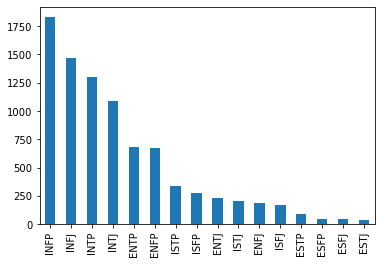

In [58]:
# showing type counts as visulaization 
df['type'].value_counts().plot(kind = 'bar')
plt.show()

Looks like INFP, INFJ, INTP are the most popular. Other types are much lower. Dataset is pretty unbalanced.


Deciding on how to deal with data imbalance. Different ways to do this could be: 
- Oversampling
- Downsampling
- SMOTE
- Near Miss
- gather more data 

 In order to handle the imbalance a good way we can convert the 16 classes into 4 classes. These new 4 classes will be more balanced. This will also make help the machine learning models classify the text as there are less classes to work with

In [59]:
# will put a 0 or 1 in the column if they contain a certian letter of the df 
df["Extrovert"] = df["type"].apply(
    lambda x: 1 if x[0] == "E" else 0
)
df["Sensing"] = df["type"].apply(
    lambda x: 1 if x[1] == "S" else 0
)
df["Thinking"] = df["type"].apply(
    lambda x: 1 if x[2] == "T" else 0
)
df["Judging"] = df["type"].apply(
    lambda x: 1 if x[3] == "J" else 0
)    

In [60]:
# rearragening columns and checking data
df = df[["type","Extrovert", "Sensing", "Thinking","Judging", "posts"]]
df.head()

,type,Extrovert,Sensing,Thinking,Judging,posts
0,INFJ,0,0,0,1,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,1,0,1,0,'I'm finding the lack of me in these posts ver...
2,INTP,0,0,1,0,'Good one _____ https://www.youtube.com/wat...
3,INTJ,0,0,1,1,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,1,0,1,1,'You're fired.|||That's another silly misconce...


 we cano now count the values of each type of person on the 4 key dimensions. They can now be characterized as: 

- Extroversion vs. Introversion
I - 0
E - 1
- Sensing vs. Intuition
N - 0
S - 1
- Thinking vs. Feeling
F - 0
T - 1
- Judging vs. Perceiving
P - 0
J - 1


In [61]:
introvert_count = df["Extrovert"].value_counts()[0]
extrovert_count = df["Extrovert"].value_counts()[1]

intuition_count = df["Sensing"].value_counts()[0]
sensing_count = df["Sensing"].value_counts()[1]

feeling_count = df["Thinking"].value_counts()[0]
thinking_count = df["Thinking"].value_counts()[1]

perceiving_count = df["Judging"].value_counts()[0]
judging_count = df["Judging"].value_counts()[1]

In [62]:
# printing all the counts
print(f"Introvert Count: {introvert_count}")
print(f"Extrovert Count: {extrovert_count}")
print(f"Intuition Count: {intuition_count}")
print(f"Sensing Count: {sensing_count}")
print(f"Feeling Count: {feeling_count}")
print(f"Thinking Count: {thinking_count}")
print(f"Perceiving Count: {perceiving_count}")
print(f"Judging Count: {judging_count}")

Introvert Count: 6676
Extrovert Count: 1999
Intuition Count: 7478
Sensing Count: 1197
Feeling Count: 4694
Thinking Count: 3981
Perceiving Count: 5241
Judging Count: 3434


Intuitiveness ,introversion , Perceptiveness all appear very often in this data set

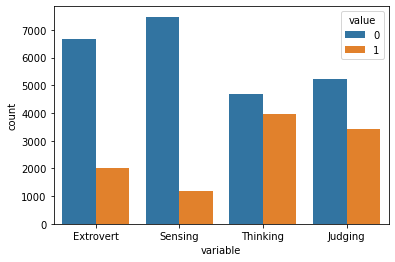

In [63]:
# we can visualize these counts 
sns.countplot(
    x="variable",
    hue="value",
    data=pd.melt(
        df[["Extrovert", "Sensing", "Thinking", "Judging"]]
    )
   
)
plt.show()

### Cleaning Data

Instead of using a tokenzier I cam just going to code out some data cleaning manually. This is for making the social media posts lower case, remove spaces, also dropping mentions of df mentioned in the posts as this could skew our models. I will make a new column for the cleaned posts.

In [68]:
# lower case 
df['cleaned posts'] = df['posts'].str.lower()

In [69]:
# replacing '|||' seperators with white space 
df['cleaned posts'] = df['cleaned posts'].str.replace(re.compile(r"\|\|\|"), " ")
df['cleaned posts'] = df['cleaned posts'].str.replace(re.compile(r"https?:\/\/(www)?.?([A-Za-z_0-9-]+)([\S])*"), "")

In [70]:
# dropping punctuations 
df['cleaned posts'] = df['cleaned posts'].str.replace(re.compile(r"[^a-z\s]"), " ")

In [71]:
# dropping emails which are not significant 
df['cleaned posts'] = df['cleaned posts'].str.replace(re.compile(r"\S+@\S+"), "")

In [72]:
# dropping df mentioned in the posts. 
mbti = df["type"].unique()
for type_word in df:
    df["cleaned posts"] = df["cleaned posts"].str.replace(type_word.lower(), "")

In [73]:
df.head()

,type,Extrovert,Sensing,Thinking,Judging,posts,cleaned posts
0,INFJ,0,0,0,1,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,enfp and intj moments sportscenter not t...
1,ENTP,1,0,1,0,'I'm finding the lack of me in these posts ver...,i m finding the lack of me in these very ala...
2,INTP,0,0,1,0,'Good one _____ https://www.youtube.com/wat...,good one of course to which i say ...
3,INTJ,0,0,1,1,"'Dear INTP, I enjoyed our conversation the o...",dear intp i enjoyed our conversation the o...
4,ENTJ,1,0,1,1,'You're fired.|||That's another silly misconce...,you re fired that s another silly misconcept...


### Normalizing Text 

For this process I am going to use lemmatization. Lemmtization switches any kind of a word to its base root mode. It has a higher accuracy rate then stemming but it takes longer. It always gives the dictionary defintion when converting to root form 
so its better when the meaning of the word is important for analysis. This will take a while to run

In [74]:
lem = WordNetLemmatizer()

df['cleaned posts'] = df['cleaned posts'].apply(
    lambda x: " ".join(
        [
            lem.lemmatize(word)
            for word in x.split(" ")
            if word not in stopwords.words("english")
                                   
        ]
    )
    
)



Lets also remove up to 2 character words that don't have much significance.  

In [76]:
df['cleaned posts'] = df['cleaned posts'].str.replace(re.compile(r'\b\w{1,2}\b'), "")

In [77]:
df.head()

,type,Extrovert,Sensing,Thinking,Judging,posts,cleaned posts
0,INFJ,0,0,0,1,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,enfp intj moment sportscenter top ten pl...
1,ENTP,1,0,1,0,'I'm finding the lack of me in these posts ver...,finding lack alarming sex boring position o...
2,INTP,0,0,1,0,'Good one _____ https://www.youtube.com/wat...,good one course say know blessing...
3,INTJ,0,0,1,1,"'Dear INTP, I enjoyed our conversation the o...",dear intp enjoyed conversation day esote...
4,ENTJ,1,0,1,1,'You're fired.|||That's another silly misconce...,fired another silly misconception approachi...


In [78]:
# drop the uneeded posts column 
df_clean = df.copy()

In [79]:
df_clean = df_clean.drop(columns = 'posts')

In [80]:
df_clean.head()

,type,Extrovert,Sensing,Thinking,Judging,cleaned posts
0,INFJ,0,0,0,1,enfp intj moment sportscenter top ten pl...
1,ENTP,1,0,1,0,finding lack alarming sex boring position o...
2,INTP,0,0,1,0,good one course say know blessing...
3,INTJ,0,0,1,1,dear intp enjoyed conversation day esote...
4,ENTJ,1,0,1,1,fired another silly misconception approachi...


In [ ]:
#save cleaned dataframe 
df_clean.to_csv(r"C:\Users\tonym\Documents\Flatiron\phase_5\capstone\MBTI-ML-Social-Media-\data\df_clean.csv", index = False)